In [2]:
import pandas as pd
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer

target_col = "label"  # "status"
ok_val = 1  # "OK"


df = pd.read_csv("train.csv")
to_drop = ["physical_part_id", "message_timestamp"]
for c in df.columns:
    if df[c].isna().all():
        to_drop.append(c)
df = df.drop(columns=to_drop)
target = df[target_col] == ok_val
df = df.drop(columns=[target_col])
categorical_features = [c for c in df.columns if "sensor" not in c]
df = pd.get_dummies(df, columns=categorical_features)
df.head()


,s6_sensor0_millimeter_step1,s8_sensor0_millimeter_step1,s8_sensor1_millimeter_step1,s7_sensor0_newton_step1,s9_sensor0_kilonewton_step1,s7_sensor1_mikrometer_step1,s0_sensor0_kilonewton_step3,s2_sensor0_millimeter_step1,s9_sensor1_sekunden (zeit)_step1,s8_sensor2_millimeter_step1,...,physical_part_type_type4,weekday_Friday,weekday_Monday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,shift_Fruehschicht,shift_Nachtschicht,shift_Spaetschicht
0,4606.469076,20.936714,390.550800,8856.466834,36.836737,32226.284706,NaN,19.696395,1056.249745,7.556479,...,False,False,False,False,False,True,False,True,False,False
1,4606.469076,18.293964,378.279734,8860.946584,36.836737,32700.200657,NaN,17.763653,1056.249745,7.119582,...,False,True,False,False,False,False,False,True,False,False
2,5886.043819,20.944510,428.742769,8849.747208,36.836737,32429.391542,-53.537243,19.582187,1056.249745,9.377910,...,False,False,False,False,False,True,False,True,False,False
3,4606.469076,18.475864,373.095553,8845.267457,36.836737,32564.796100,NaN,18.238053,1056.249745,7.541095,...,False,False,False,False,True,False,False,True,False,False
4,4606.469076,19.801137,382.829679,8847.507333,36.836737,33309.521166,NaN,19.178068,1013.999755,8.282590,...,False,False,True,False,False,False,False,False,False,True


In [3]:
target.mean()


0.9492512891709639

In [4]:
# Take 90% of data for training
df_train = df.sample(frac=0.9, random_state=42)
df_val = df.drop(df_train.index)
target_train = target.iloc[df_train.index]
target_val = target.iloc[df_val.index]

print(df_train.shape, df_val.shape)


(36302, 365) (4034, 365)


In [5]:
X_train = df_train.values
y_train = target_train.values
X_val = df_val.values
y_val = target_val.values

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)


(36302, 365) (36302,) (4034, 365) (4034,)


In [6]:
imputer = SimpleImputer(strategy="mean")
X_train = imputer.fit_transform(X_train)
X_val = imputer.transform(X_val)


In [7]:
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)


In [8]:
# Train XGBoost on balanced data
tree = xgb.XGBClassifier()
tree.fit(X_train_balanced, y_train_balanced)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

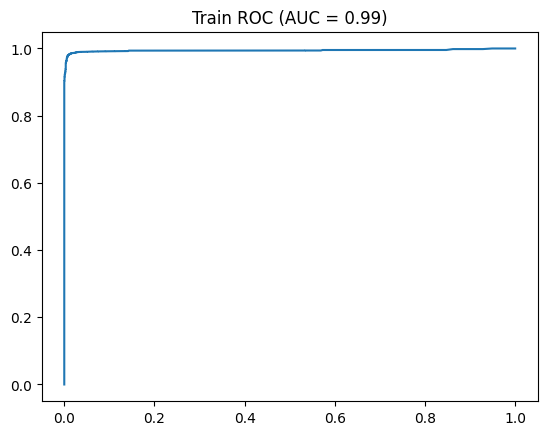

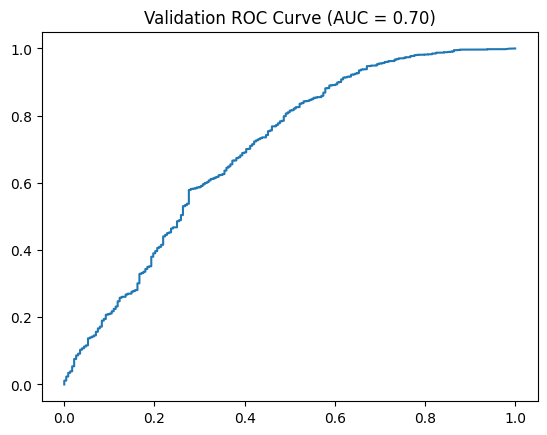

In [9]:
# Plot ROC curve on train
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve

y_pred = tree.predict_proba(X_train)[:, 1]
fpr, tpr, thresholds = roc_curve(y_train, y_pred)
roc_auc = auc(fpr, tpr)
plt.title(f"Train ROC (AUC = {roc_auc:.2f})")
plt.plot(fpr, tpr)
plt.show()

y_pred = tree.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)
plt.title(f"Validation ROC Curve (AUC = {roc_auc:.2f})")
plt.plot(fpr, tpr)
plt.show()


In [10]:
test_df = pd.read_csv("test.csv")
test_df = test_df.drop(columns=to_drop)
test_df = pd.get_dummies(test_df, columns=categorical_features)
test_df.head()

X_test = test_df.values
X_test = imputer.transform(X_test)
y_pred = tree.predict_proba(X_test)[:, 1]

print(y_pred.shape)
print(y_pred[:10])


(4482,)
[0.9786349  0.9727286  0.9967187  0.9953252  0.9975751  0.93293613
 0.1553099  0.9981937  0.99680126 0.9829113 ]


In [11]:
sample_submission = pd.read_csv("sample_submission.csv")
sample_submission["label"] = y_pred
sample_submission.to_csv("submission.csv", index=False)


In [12]:
print(len(test_df), len(sample_submission))


4482 4482
